In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [3]:
class Value:

  def __init__(self, data, _children=(), _op='',label= ''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.grad = 0.0
    self._backward = lambda: None
    self.label = label

  def __repr__(self):
    return f'Data: {self.data}'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward
    return out

  def __radd__(self, other): # other + self
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __pow__(self, other):
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    val = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(val, (self,), 'tanh')
    def _backward():
      self.grad += (1 - val**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1
    for vertex in reversed(topo):
      vertex._backward()


In [4]:
a = Value(2, label='a')
b = Value(3, label='b')
c = Value(6, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(5, label='f')
L = f*d; L.label = 'L'

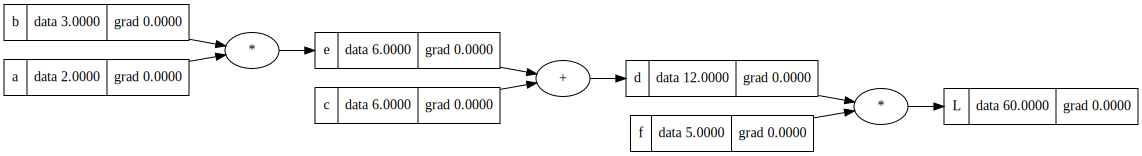

In [5]:
draw_dot(L)

# **Building a Neuron**



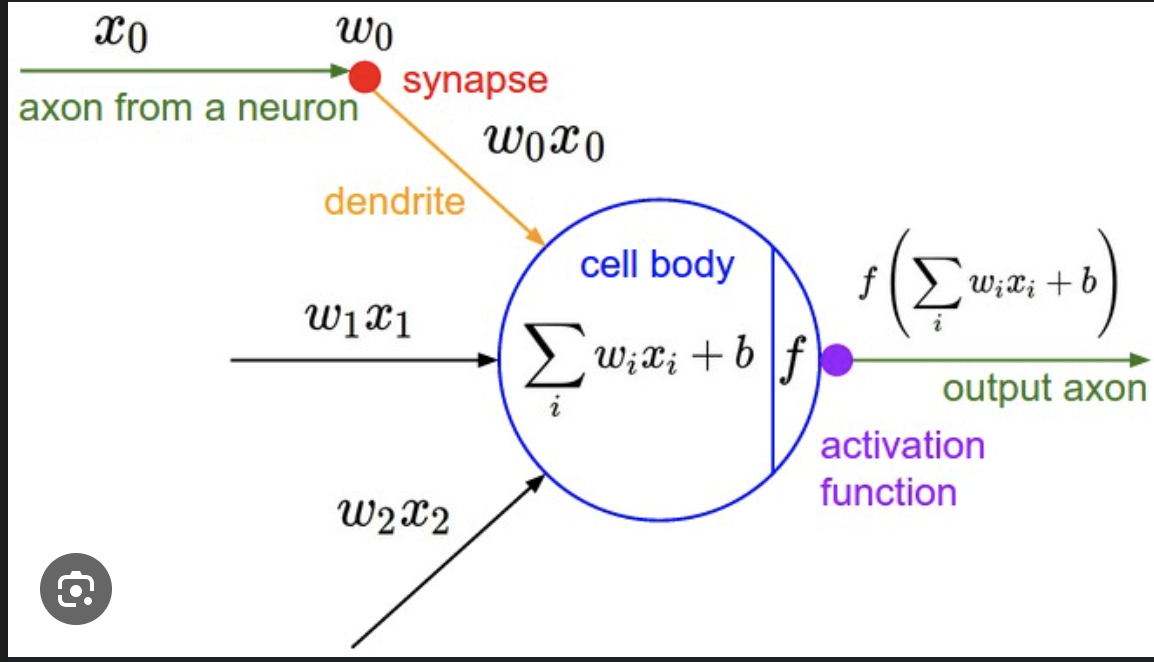

In [6]:
x1 = Value(2.0, label='x1')
w1 = Value(-3.0, label='w1')
x2 = Value(0.0, label='x2')
w2 = Value(1.0, label='w2')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

b = Value(6.8813735870195432, label ='b')
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

L = x1w1x2w2 + b; L.label = 'L'
o = L.tanh(); o.label = 'o'

In [7]:
o.backward()

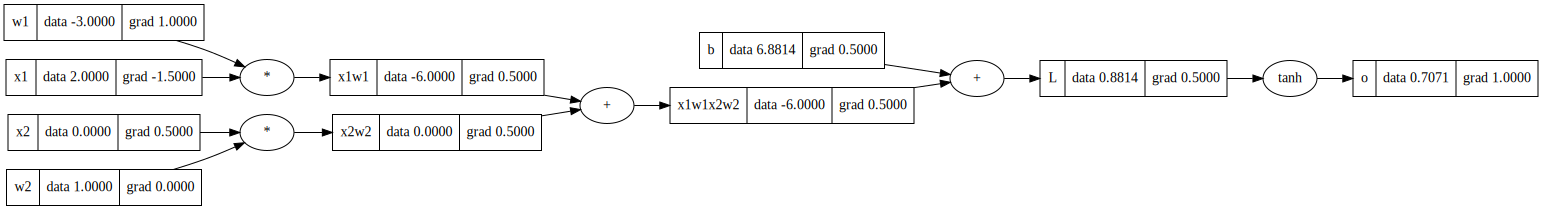

In [8]:
draw_dot(o)

# **See the effect of grad on the value of output**

In [9]:
h = 0.01

w1.data += h*w1.grad
w2.data += h*w2.grad
b.data += h*b.grad

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

L = x1w1x2w2 + b; L.label = 'L'
o = L.tanh(); o.label = 'o'


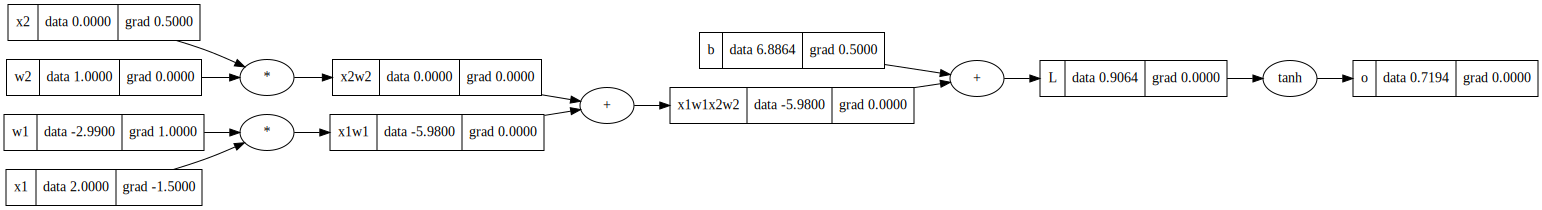

In [10]:
draw_dot(o)

Thus we can increase the value of L and hence output if move the weigths in the direction of grad

# **Using Pytorch**

In [11]:
import torch

In [12]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# **Building a Multi Layer preceptron**

In [13]:
import random
class Neuron:

  def __init__(self, _input_count):
    self.weights = [Value(random.uniform(-1, 1)) for _ in range(_input_count)]
    self.bias = Value(random.uniform(-1, 1))


  def __call__(self, x):
    ans = []
    for xi, weight in zip(x, self.weights):
        ans.append(xi * weight)
    out = sum(ans) + self.bias
    return out.tanh()

  def parameters(self):
    return self.weights + [self.bias]

class Layer:
   def __init__(self, _input_count, num_in_layer):
    self.neurons = [Neuron(_input_count) for _ in range(num_in_layer)]

   def __call__(self, x):
    outs = []
    for neuron in self.neurons:
      outs.append(neuron(x))
    return outs[0] if len(outs) == 1 else outs

   def parameters(self):
    params = []
    for neuron in self.neurons:
      params.extend(neuron.parameters())
    return params

class MLP:

  def __init__(self, nin, nouts):
    self.layers = []
    sz = [nin] + nouts
    for i in range(1, len(sz)):
      self.layers.append(Layer(sz[i-1], sz[i]))

  def __call__(self, x):
    out = []
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    params = []
    for layer in self.layers:
      params.extend(layer.parameters())
    return params

In [14]:
n = Neuron(2)
x = [2.0, 3.0]
n(x)

Data: 0.3636944355018774

In [15]:
n = Layer(2, 3)
x = [2.0, 3.0]
n(x)

[Data: 0.9731131314463307,
 Data: -0.9533498354332423,
 Data: -0.9331396006653375]

In [16]:
n = MLP(3, [4, 4, 1])
x = [2.0, 3.0, -1.0]
n(x)

Data: 0.3273374735891952

In [17]:
#draw_dot(n(x))

In [18]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [19]:
n = MLP(3, [4, 4, 1])
number_of_iterations = 100
learning_rate = 0.01

In [20]:
#draw_dot(loss)

In [21]:
len(n.parameters())

41

In [22]:
for i in range(number_of_iterations):
  y_pred = []
  for x in xs:
    y_pred.append(n(x))
  loss = sum((yout-ygt)**2 for yout, ygt in zip(y_pred, ys))
  if i % 10 ==0 :
    print(f'The loss is {i}th iteration is {loss.data}')

  for p in n.parameters():
    p.grad = 0
  loss.backward()
  for param in n.parameters():
    param.data -= learning_rate * param.grad


The loss is 0th iteration is 5.31335199988699
The loss is 10th iteration is 0.9381918078384774
The loss is 20th iteration is 0.37076956527364946
The loss is 30th iteration is 0.21036717468794627
The loss is 40th iteration is 0.1413203441473462
The loss is 50th iteration is 0.10436625122941368
The loss is 60th iteration is 0.08181476653448973
The loss is 70th iteration is 0.0668016089157652
The loss is 80th iteration is 0.056171666248065175
The loss is 90th iteration is 0.04829247274604036


In [23]:
y_pred

[Data: 0.9179916318307875,
 Data: -0.8601077243331048,
 Data: -0.9540422773853205,
 Data: 0.880102259754808]

###                                      **THE** **END**